# 关于 Barra Non-linear Size 差异的分析与解决

1. 主要原因就在于 winsorization 的阈值不一样，导致我们算出来的 size 跟 华泰他们算的有shift，从而影响了Non-linear size 的计算

下面的程序，我调整了一个计算size的shift，只要我们保证size跟华泰算的size一样，没有shift，就能得到很好的结果，相关系数 99.8%

2. 华泰在算这个 Non-linear size 的时候，用的是 总市值，而不是 流通市值

3. 另外，我们在做个factor的时候，不能只看相关系数，最好还是把对比的图做一下，看起来清晰，确定是比较好的线性关系

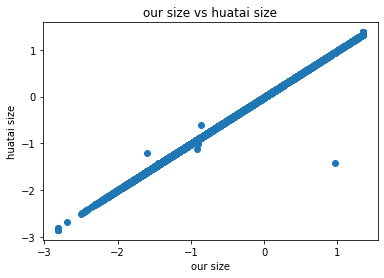

correlation between our and huatai non-linear size:  0.9980302960337257


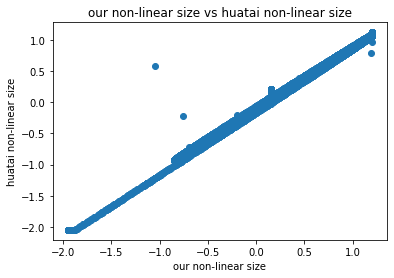

In [368]:
import os,sys,math
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from ElephasReader import DataReader as dr

def winsorization(series:pd.Series, bounds:tuple=(0.1, 0.9)):
    s = series.copy()
    lower, upper = s.quantile([bounds[0], bounds[1]])
    s = s.where(s <= upper, upper)
    s = s.where(s >= lower, lower)
    return s

def standarization(factor:pd.Series, weight:pd.Series, bounds:tuple=(0.1, 0.9)):
    factor = factor.copy(deep=True)

    weight = winsorization(weight, bounds)
    factor = winsorization(factor, bounds)

    mean = ((weight / weight.sum()) * factor).sum()
    factor = (factor - mean) / factor.std(ddof=0)

    return factor 


def standarization_spec(factor:pd.Series, weight:pd.Series, bounds:tuple=(0.1, 0.9)):
    factor = factor.copy(deep=True)

    weight = winsorization(weight, (0.05, 0.72))
    factor = winsorization(factor, (0.001, 0.92))

    mean = ((weight / weight.sum()) * factor).sum()
    factor = (factor - mean) / factor.std(ddof=0)

    return factor 


dt = '2022-05-05'
df = dr.get_equ_mkt_daily(begin_date=dt, end_date=dt)
df = df.set_index('stock_code').sort_index()
df_ht = pd.read_csv(f'files/huatai_barra/{dt}.csv', encoding='gbk', index_col=0).dropna()


mcap = pd.Series(data=df_ht.index.map(df['tcap']).to_list(), index=df_ht.index) 
lncap = standarization_spec(np.log(mcap), mcap)
lncap3 = lncap.pow(3)

lncap_ht = df_ht['市值']
lncap3_ht = lncap_ht.pow(3)

plt.scatter(lncap, lncap_ht)
plt.title("our size vs huatai size")
plt.xlabel('our size')
plt.ylabel('huatai size')
plt.show()


reg = LinearRegression().fit(lncap.to_numpy().reshape((-1,1)), lncap3, mcap)
lnre = lncap3 - reg.predict(lncap.to_numpy().reshape((-1,1)))
lnre = standarization(lnre, mcap)


# reg_ht = LinearRegression().fit(lncap_ht.to_numpy().reshape((-1,1)), lncap3_ht, mcap)
# lnre_ht = lncap3_ht - reg_ht.predict(lncap_ht.to_numpy().reshape((-1,1)))
# lnre_ht = standarization(lnre_ht, mcap)

print("correlation between our and huatai non-linear size: ", lnre.corr(df_ht['非线性市值']))

plt.scatter(lnre, df_ht['非线性市值'])
plt.title("our non-linear size vs huatai non-linear size")
plt.xlabel("our non-linear size")
plt.ylabel("huatai non-linear size")
plt.show()